# Lorenz SBI

This notebook incorporates the whole workflow of the Lorenz example on the GitHub of krisevers. The goal of this notebook is to put all the different files into 1 file and display all figures and comments into 1 notebook for convenience purposes.

First import the needed libaries.

In [38]:
import os
import numpy as np
import pylab as plt
import argparse 

import torch
import sbi.utils as utils
from sbi.inference import SNPE, SNLE, SNRE
from sbi.analysis import pairplot, conditional_pairplot
from lorenz import lorenz, statistics
from scipy.integrate import odeint
from utils import marginal_correlation

# If needed, before starting, change the current working directory by uncommenting and inserting the right path in the following line of code.
#os.chdir("/home/coder/projects/lorenz_sbi")

# Throughout the code I inserted the path that I want to files saved in or taken from. Change this to your own path before starting!

The following code is derived from train.py in the original GitHub repository.

In [41]:
def train(num_simulations,
          x, 
          theta,
          num_threads=1,
          method="SNPE",
          device="cpu",
          density_estimator="maf"):
    
    torch.set_num_threads(num_threads)

    if (len(x.shape) == 1):
        x = x[:, None]
    if (len(theta.shape) == 1):
        theta = theta[:, None]


    if (method == "SNPE"):
        inference = SNPE(
            density_estimator=density_estimator, device=device
        )
    elif (method == "SNLE"):
        inference = SNLE(
            density_estimator=density_estimator, device=device
        )
    elif (method == "SNRE"):
        inference = SNRE(
            density_estimator=density_estimator, device=device
        )
    else:
        raise ValueError("Unknown inference method")
    
    inference = inference.append_simulations(theta, x)
    _density_estimator = inference.train()
    posterior = inference.build_posterior(_density_estimator)

    return posterior

def infer(obs_stats,
          num_samples,
          posterior):
    return posterior.sample((num_samples,), x=obs_stats)

parser = argparse.ArgumentParser(description="Train a density estimator on the Lorenz system.")
# Insert own path if needed.
parser.add_argument("--data", type=str, default="/home/coder/projects/lorenz_sbi/data/X.npy", help="Path to the data file.")
parser.add_argument("--method", type=str, default="SNPE", help="Inference method.")
parser.add_argument("--density_estimator", type=str, default="maf", help="Density estimator.")
parser.add_argument("--num_threads", type=int, default=1, help="Number of threads.")
parser.add_argument("--device", type=str, default="cpu", help="Device.")

#args = parser.parse_args()

# According to Stackoverflow change the above line to:
args, unknown = parser.parse_known_args()

X = np.load(args.data, allow_pickle=True)

params = X[:, -3:]
stats  = X[:, :-3]

num_simulations = X.shape[0]

theta = torch.from_numpy(params).float()
x = torch.from_numpy(stats).float()

# Neural network converges after 94 epochs for the lorenz example.
posterior = train(num_simulations,
                    x,
                    theta,
                    num_threads         = args.num_threads,
                    method              = args.method,
                    device              = args.device,
                    density_estimator   = args.density_estimator
                    )

# Save posterior.
# Insert own path if needed.
torch.save(posterior, "/home/coder/projects/lorenz_sbi/models/posterior.pt")

 Neural network successfully converged after 136 epochs.

The following code is derived from posterior.py from the original GitHub repository.
The original parameters were: σ = 10, β = 8/3 and ρ = 28.

Drawing 100000 posterior samples:  10%|█         | 10000/100000 [00:00<00:01, 83968.87it/s]

Drawing 100000 posterior samples: 100%|██████████| 100000/100000 [00:01<00:00, 84802.10it/s]


<Figure size 640x480 with 0 Axes>

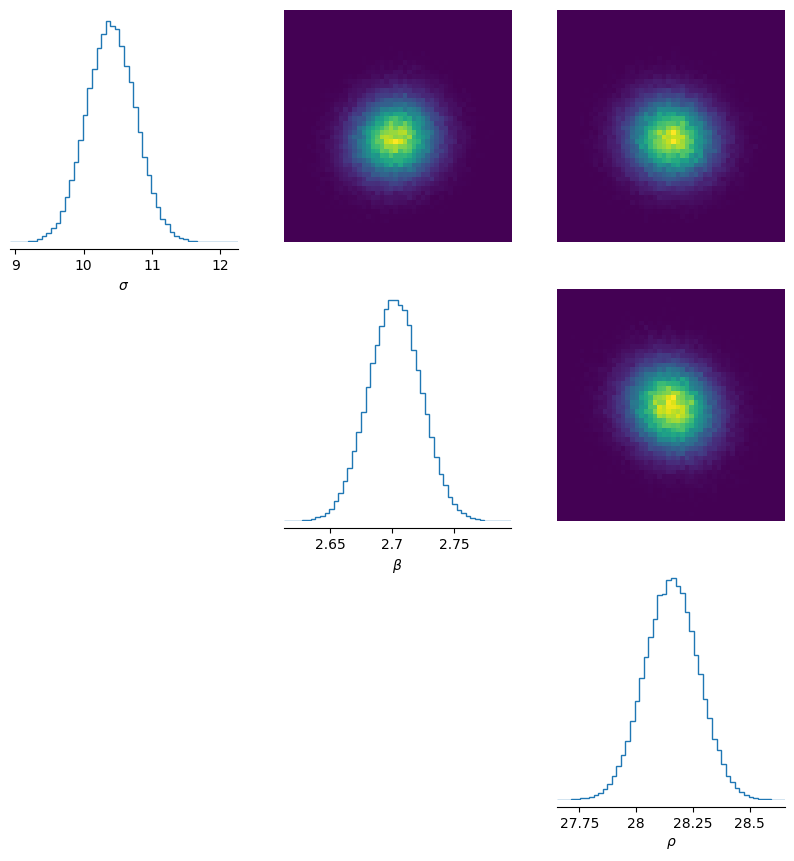

<Figure size 640x480 with 0 Axes>

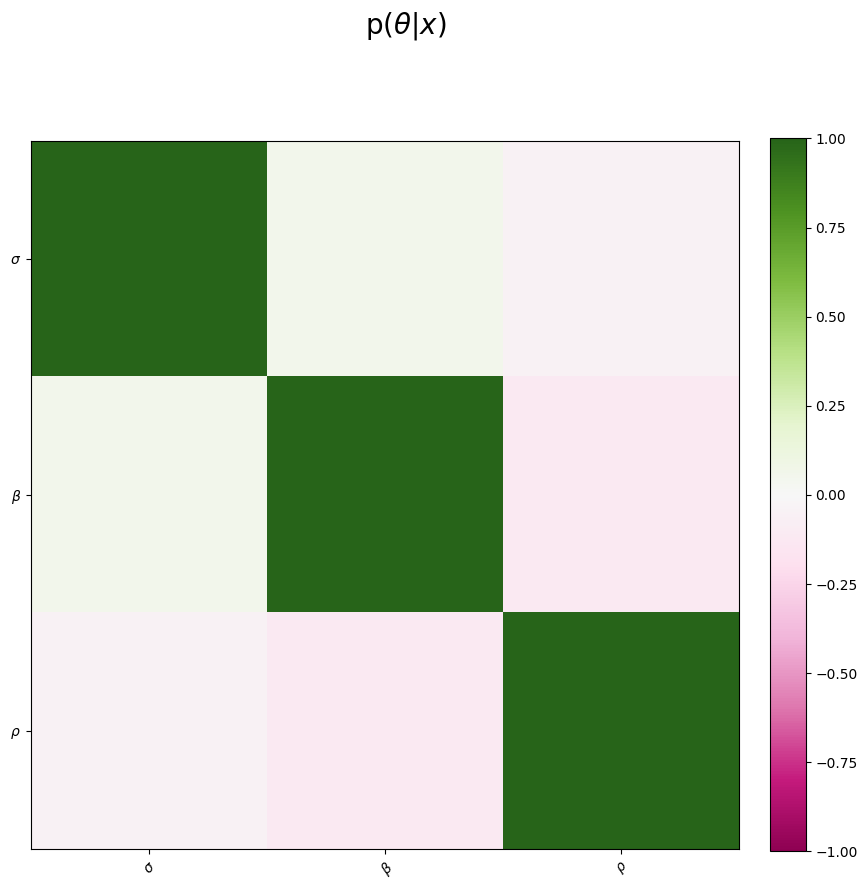

In [42]:
# Set the Lorenz parameters.
sigma = 10.0
beta  = 8.0 / 3.0
rho   = 28.0

# Set the initial condition.
x0 = np.array([0.0, 1.0, 1.05])

# Set the time sample.
t = np.linspace(0.0, 100.0, 1000)

# Solve the ODE.
x_t = odeint(lorenz, x0, t, args=(sigma, beta, rho))

mean, cov, cor, eigvals, eigvecs, lyap = statistics(x_t)

obs_x = np.concatenate([mean, cov.flatten(), cor.flatten()])
obs_theta = [sigma, beta, rho]

# Load posterior.
# Insert own path if needed.
posterior = torch.load("/home/coder/projects/lorenz_sbi/models/posterior.pt")

num_samples = 100000

posterior.set_default_x(obs_x)
posterior_samples = posterior.sample((num_samples,))

plt.figure()
fig, ax = pairplot(samples=posterior_samples, labels=[r"$\sigma$", r"$\beta$", r"$\rho$"], figsize=(10, 10))
plt.show()
#plt.savefig("/home/coder/projects/lorenz_sbi/png/pairplot.png")

plt.figure()
fig, ax = marginal_correlation(samples=posterior_samples, labels=[r"$\sigma$", r"$\beta$", r"$\rho$"], figsize=(10, 10))
plt.show()
#plt.savefig("/home/coder/projects/lorenz_sbi/png/marginal_correlation.png")

